In [1]:
%matplotlib inline
import numpy as np
import firedrake
from firedrake import sym, inner, grad, div, dx, ds, \
    MixedVectorSpaceBasis, VectorSpaceBasis, DirichletBC

In [2]:
def ɛ(u):
    return sym(grad(u))

In [3]:
N = 64
mesh = firedrake.UnitSquareMesh(64, 64)
Q = firedrake.FunctionSpace(mesh, 'CG', 1)
V = firedrake.VectorFunctionSpace(mesh, 'CG', 2)
Z = V * Q

In [4]:
μ = firedrake.Constant(1.0)  # viscosity coefficient

In [5]:
parameters = {
    'mat_type': 'matfree',
    'ksp_type': 'gmres',
    'ksp_monitor_residual': True,
    'ksp_view': True,
    'pc_type': 'fieldsplit',
    'pc_fieldsplit_type': 'schur',
    'pc_fieldsplit_schur_fact_type': 'diag',
    'fieldsplit_0_ksp_type': 'preonly',
    'fieldsplit_0_pc_type': 'python',
    'fieldsplit_0_pc_python_type': 'firedrake.AssembledPC',
    'fieldsplit_0_assembled_pc_type': 'hypre',
    'fieldsplit_1_ksp_type': 'preonly',
    'fieldsplit_1_pc_type': 'python',
    'fieldsplit_1_pc_python_type': 'firedrake.MassInvPC',
    'fieldsplit_1_Mp_ksp_type': 'preonly',
    'fieldsplit_1_Mp_pc_type': 'ilu'
}

nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True)])

### Traditional method

Since our domain is a square, we can get away with directly imposing the Dirichlet part of the friction BCs by setting a component of the velocity field to 0.
For arbitrary domains, we don't have this option.

In [6]:
def solve_dirichlet(κ, u_κ):
    z = firedrake.Function(Z)
    u, p = firedrake.split(z)

    n = firedrake.FacetNormal(mesh)
    u_n = inner(u, n)
    Pu = u - u_n * n
    
    J_viscous = μ * inner(ɛ(u), ɛ(u)) * dx
    J_pressure = p * div(u) * dx
    J_friction = 0.5 * κ * inner(Pu - u_κ, Pu - u_κ) * ds((4,)) \
                + 0.5 * κ * inner(Pu, Pu) * ds((1, 2, 3))
    J = J_viscous - J_pressure + J_friction

    bc_x = DirichletBC(Z.sub(0).sub(0), firedrake.Constant(0), (1, 2))
    bc_y = DirichletBC(Z.sub(0).sub(1), firedrake.Constant(0), (3, 4))

    firedrake.solve(firedrake.derivative(J, z) == 0, z, bcs=[bc_x, bc_y],
                    nullspace=nullspace,
                    solver_parameters=parameters)
    return z.split()

### Nitsche method

We're using the P2-P1 velocity-pressure pair for the Stokes equations.
Consequently the derivative of the velocity is is linear in each triangle, so we'll take the degree to be 1 for the constant in the Warburton-Hesthaven theorem.
On the other hand we have `d**2` components of the stress tensor.

In [7]:
from mesh_util import minimum_angle
θ = minimum_angle(mesh)
k, d = 2, 2
η = 2 * d * k * (k + d - 1) / np.cos(θ) / np.tan(θ/2)

def solve_nitsche(κ, u_κ):
    z = firedrake.Function(Z)
    u, p = firedrake.split(z)

    h = firedrake.CellSize(mesh)
    n = firedrake.FacetNormal(mesh)
    u_n = inner(u, n)
    Pu = u - u_n * n

    I = firedrake.Identity(2)
    σ_n = inner(n, (2 * μ * ɛ(u) - p * I) * n)

    J_viscous = μ * inner(ɛ(u), ɛ(u)) * dx
    J_pressure = p * div(u) * dx
    J_friction = 0.5 * κ * inner(Pu - u_κ, Pu - u_κ) * ds((4,)) \
                + 0.5 * κ * inner(Pu, Pu) * ds((1, 2, 3))
    J_lagrange = σ_n * u_n * ds
    J_penalty = 0.5 * η * μ / h * u_n**2 * ds
    J = J_viscous - J_pressure + J_friction - J_lagrange + J_penalty
    
    firedrake.solve(firedrake.derivative(J, z) == 0, z,
                    nullspace=nullspace,
                    solver_parameters=parameters)
    return z.split()

In [8]:
κ = firedrake.Constant(1.0)
u_κ = firedrake.as_vector((0.5, 0.0))

In [9]:
u_dirichlet, p_dirichlet = solve_dirichlet(κ, u_κ)
u_nitsche, p_nitsche = solve_nitsche(κ, u_κ)

In [10]:
firedrake.norm(u_dirichlet - u_nitsche)

1.3112032117438878e-06

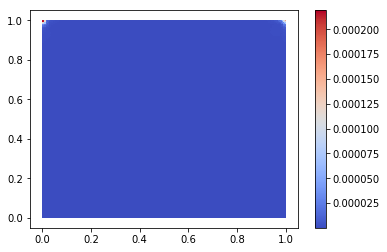

In [11]:
δu = u_dirichlet - u_nitsche
firedrake.plot(firedrake.interpolate(firedrake.sqrt(inner(δu, δu)), Q))

### Fancy plots

In [12]:
xs = np.linspace(0, 1, N + 1)
ys = np.linspace(0, 1, N + 1)

U = np.zeros((2, N+1, N+1))
for j, x in enumerate(xs):
    for i, y in enumerate(ys):
        U[:, i, j] = u_nitsche.at((x, y), tolerance=1e-12)

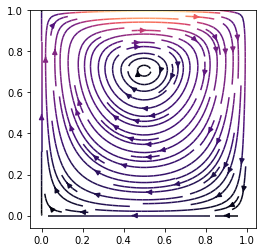

In [13]:
import matplotlib.pyplot as plt

speed = np.sqrt(U[0,:,:]**2 + U[1,:,:]**2)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.streamplot(xs, ys, U[0,:,:], U[1,:,:], color=speed, density=1.2, cmap='magma')
plt.show(fig)

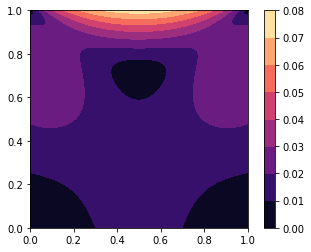

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ctr = ax.contourf(xs, ys, speed, cmap='magma')
fig.colorbar(ctr)
plt.show(fig)